In [1]:
# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:04:09.840829Z","start_time":"2020-04-03T23:04:07.112516Z"}}
#######################################################
# Much of this comes from https://www.kaggle.com/pradeeppathak9/gamma-log-facies-type-prediction
# https://www.crowdanalytix.com/contests/gamma-log-facies-type-prediction
######################################################
import os
os.system('pip install pytorch_toolbelt')
import pandas as pd
import numpy as np
import json
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import time

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from sklearn.model_selection import KFold
import gc

from tqdm import tqdm
from itertools import groupby, accumulate
from random import shuffle

from sklearn.model_selection import GroupKFold, GroupShuffleSplit, LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler
from pytorch_toolbelt import losses as L

from scipy import signal

In [25]:
# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:04:12.145471Z","start_time":"2020-04-03T23:04:12.141914Z"}}
# PATH = '/kaggle/input/'
PATH = '/Users/helen/Desktop/Data/'
SEQ_LEN = 4000
GROUP_PER_BATCH = 500000//SEQ_LEN
window_sizes = [5, 10]
NFea = [4, 6, 6]


# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:04:14.838509Z","start_time":"2020-04-03T23:04:14.822835Z"}}
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if col != 'time':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:04:20.620083Z","start_time":"2020-04-03T23:04:17.837634Z"}}
ss = pd.read_csv(PATH + "liverpool-ion-switching/sample_submission.csv", dtype={'time':str})
train = pd.read_csv(PATH +'clean-kalman/train_clean_kalman.csv')
train['filter'] = 0
test = pd.read_csv(PATH +'clean-kalman/test_clean_kalman.csv')
test['filter'] = 2

In [26]:
# %% [code]


# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:04:29.265784Z","start_time":"2020-04-03T23:04:23.756861Z"}}
# %%time
# for window in window_sizes:
#     train["rolling_mean_" + str(window)] = train['signal'].rolling(window=window).mean()
#     train["rolling_std_" + str(window)] = train['signal'].rolling(window=window).std()
#     train["rolling_var_" + str(window)] = train['signal'].rolling(window=window).var()
#     train["rolling_min_" + str(window)] = train['signal'].rolling(window=window).min()
#     train["rolling_max_" + str(window)] = train['signal'].rolling(window=window).max()
    
#     train["rolling_mean_" + str(window)+"_diff"] = train["rolling_mean_" + str(window)] - train['signal']
#     train["rolling_std_" + str(window)+"_diff"] = train["rolling_std_" + str(window)] - train['signal']
#     train["rolling_var_" + str(window)+"_diff"] = train["rolling_var_" + str(window)] - train['signal']
#     train["rolling_min_" + str(window)+"_diff"] = train["rolling_min_" + str(window)] - train['signal']
#     train["rolling_max_" + str(window)+"_diff"] = train["rolling_max_" + str(window)] - train['signal']  
#     #train["rolling_min_max_ratio_" + str(window)] = train["rolling_min_" + str(window)] / train["rolling_max_" + str(window)]
#     #train["rolling_min_max_diff_" + str(window)] = train["rolling_max_" + str(window)] - train["rolling_min_" + str(window)]
    
#     a = (train['signal'] - train['rolling_min_' + str(window)]) / (train['rolling_max_' + str(window)] - train['rolling_min_' + str(window)])
#     train["norm_" + str(window)] = a * (np.floor(train['rolling_max_' + str(window)]) - np.ceil(train['rolling_min_' + str(window)]))
    
# train = train.replace([np.inf, -np.inf], np.nan)    
# train.fillna(0, inplace=True)

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:04:34.073285Z","start_time":"2020-04-03T23:04:32.404428Z"}}
# %%time
# for window in window_sizes:
#     test["rolling_mean_" + str(window)] = test['signal'].rolling(window=window).mean()
#     test["rolling_std_" + str(window)] = test['signal'].rolling(window=window).std()
#     test["rolling_var_" + str(window)] = test['signal'].rolling(window=window).var()
#     test["rolling_min_" + str(window)] = test['signal'].rolling(window=window).min()
#     test["rolling_max_" + str(window)] = test['signal'].rolling(window=window).max()
    
#     test["rolling_mean_" + str(window)+"_diff"] = test["rolling_mean_" + str(window)] - test['signal']
#     test["rolling_std_" + str(window)+"_diff"] = test["rolling_std_" + str(window)] - test['signal']
#     test["rolling_var_" + str(window)+"_diff"] = test["rolling_var_" + str(window)] - test['signal']
#     test["rolling_min_" + str(window)+"_diff"] = test["rolling_min_" + str(window)] - test['signal']
#     test["rolling_max_" + str(window)+"_diff"] = test["rolling_max_" + str(window)] - test['signal']  
    
#     #test["rolling_min_max_ratio_" + str(window)] = test["rolling_min_" + str(window)] / test["rolling_max_" + str(window)]
#     #test["rolling_min_max_diff_" + str(window)] = test["rolling_max_" + str(window)] - test["rolling_min_" + str(window)]

    
#     a = (test['signal'] - test['rolling_min_' + str(window)]) / (test['rolling_max_' + str(window)] - test['rolling_min_' + str(window)])
#     test["norm_" + str(window)] = a * (np.floor(test['rolling_max_' + str(window)]) - np.ceil(test['rolling_min_' + str(window)]))

# test = test.replace([np.inf, -np.inf], np.nan)    
# test.fillna(0, inplace=True)

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:07:30.632968Z","start_time":"2020-04-03T23:04:37.769007Z"}}
# %%time
# def features(df):
#     df = df.sort_values(by=['time']).reset_index(drop=True)
#     df.index = ((df.time * 10_000) - 1).values
#     df['batch'] = df.index // 25_000
#     df['batch_index'] = df.index  - (df.batch * 25_000)
#     df['batch_slices'] = df['batch_index']  // 2500
#     df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), 
#                                                        str(r['batch_slices']).zfill(3)]), axis=1)
    
#     for c in ['batch','batch_slices2']:
#         d = {}
#         d['mean'+c] = df.groupby([c])['signal'].mean()
# #         print(d['mean'+c])
#         d['median'+c] = df.groupby([c])['signal'].median()
#         d['max'+c] = df.groupby([c])['signal'].max()
#         d['min'+c] = df.groupby([c])['signal'].min()
#         d['std'+c] = df.groupby([c])['signal'].std()
#         d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
#         d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
#         d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
#         d['range'+c] = d['max'+c] - d['min'+c]
#         d['maxtomin'+c] = d['max'+c] / d['min'+c]
#         d['abs_avg'+c] = (d['abs_min'+c] + d['abs_max'+c]) / 2
# #         print('--------------------')
#         for v in d:
#             df[v] = df[c].map(d[v].to_dict())
    
#     # add shifts_1
#     df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
#     df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
#     for i in df[df['batch_index']==0].index:
#         df['signal_shift_+1'][i] = np.nan
#     for i in df[df['batch_index']==49999].index:
#         df['signal_shift_-1'][i] = np.nan
    
#     # add shifts_2 - my upgrade
#     df['signal_shift_+2'] = [0,] + [1,] + list(df['signal'].values[:-2])
#     df['signal_shift_-2'] = list(df['signal'].values[2:]) + [0] + [1]
#     for i in df[df['batch_index']==0].index:
#         df['signal_shift_+2'][i] = np.nan
#     for i in df[df['batch_index']==1].index:
#         df['signal_shift_+2'][i] = np.nan
#     for i in df[df['batch_index']==49999].index:
#         df['signal_shift_-2'][i] = np.nan
#     for i in df[df['batch_index']==49998].index:
#         df['signal_shift_-2'][i] = np.nan
    
#     df = df.drop(columns=['batch', 'batch_index', 'batch_slices', 'batch_slices2'])

#     for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels']]:
#         df[c+'_msignal'] = df[c] - df['signal']
        
#     df = df.replace([np.inf, -np.inf], np.nan)    
#     df.fillna(0, inplace=True)
#     gc.collect()
#     return df

# train = features(train)
# test = features(test)

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:16:35.157641Z","start_time":"2020-04-03T23:15:50.454252Z"}}
# train = reduce_mem_usage(train)

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:20:37.936034Z","start_time":"2020-04-03T23:20:21.086950Z"}}
# test = reduce_mem_usage(test)

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T18:35:47.275695Z","start_time":"2020-04-03T18:35:47.253657Z"}}
# pd.cut(np.array([1, 7, 5, 4, 6, 3]), 3)

# %% [code]

In [27]:
# %% [code]
# normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test, div = 1.0):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma / div
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma / div
    return train, test

# %% [code]

print("before normalize")
orgnorm = 15.0
print(max(train['signal'])/orgnorm, min(train['signal'])/orgnorm)
print(max(test['signal'])/orgnorm, min(test['signal'])/orgnorm)

print("after normalize")
train, test = normalize(train, test, div=6.0) ## margic number
print('Reading and Normalizing Data Completed')

print(max(train['signal']), min(train['signal']))
print(max(test['signal']), min(test['signal']))

before normalize
0.5712801709920725 -0.3844742898121893
0.5570543031187908 -0.3635959906107261
after normalize
Reading and Normalizing Data Completed
0.5696501880988262 -0.39265437555998145
0.555326825626684 -0.37163299043759834


In [28]:
from pykalman import KalmanFilter

def Kalman1D(observations,damping=1):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state

In [29]:
# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:21:08.254985Z","start_time":"2020-04-03T23:21:05.328127Z"}}
ts1 = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)
ts1.head()

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:21:23.618036Z","start_time":"2020-04-03T23:21:22.475969Z"}}
# 将每个batch一个time2 bin
ts1['time2'] = pd.cut(ts1['time'], bins=np.linspace(0.0000, 700., num=14 + 1), labels=list(range(14)), 
                      include_lowest=True).astype(int)
#每个batch time2 做归一化
ts1['time2'] = ts1.groupby('time2')['time'].rank( )/500000. 

#将每个batch变成125个group
np.random.seed(321)
ts1['group'] = pd.cut(ts1['time'], bins=np.linspace(0.0000, 700., num=14*GROUP_PER_BATCH + 1), 
                      labels=list(range(14*GROUP_PER_BATCH)), 
                      include_lowest=True).astype(int)
np.random.seed(321)
ts1.head()
# signal processing features
def calc_gradients(s, df, n_grads = 4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        df['grad_' + str(i+1)] = g
        
    return df

def calc_low_pass(s, df, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    print("low wns:", wns)
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        print("low wn:{},b:{},a:{}".format(wn, b, a))
        zi = signal.lfilter_zi(b, a)
        df['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        df['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return df

def calc_high_pass(s, df, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    print("high wns:", wns)
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        print("high wn:{},b:{},a:{}".format(wn, b, a))
        zi = signal.lfilter_zi(b, a)
        df['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        df['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return df

def calc_ewm(s, df, windows=[10, 50, 100, 500, 1000]):
    '''
    Calculates exponential weighted functions
    '''
    for w in windows:
        df['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        df['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
#     # add zeros when na values (std)
#     df = df.fillna(value=0)
        
    return df


def add_features(df):
    '''
    All calculations together
    '''
    s = df['signal']
    df = calc_gradients(s, df, n_grads = NFea[0])
    df = calc_low_pass(s, df, n_filts = NFea[1])
    df = calc_high_pass(s, df, n_filts = NFea[2])
    df = calc_ewm(s, df, windows=window_sizes)
    
    return df
# %% [code]
# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df

# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df):
    # create leads and lags (1, 2, 3 making them 6 features)
    df = add_features(df)
    df = lag_with_pct_change(df, [1, 2, 3])
    # create signal ** 2 (this is the new feature)
    df['signal_2'] = df['signal'] ** 2
    return df

# fillna with the mean and select features for training
def feature_selection_org(train, test):
    features = use_cols
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features

def feature_selection(data, features):
    data = data.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = data[feature].mean()
        data[feature] = data[feature].fillna(feature_mean)
    return data, features

# %% [code]
print('Creating Features')
print('Feature Engineering Started...')
ts1 = run_feat_engineering(ts1)
use_cols = [col for col in ts1.columns if col not in ['index','filter','group', 'open_channels', 'time', 'time2', 
                                                      'medianbatch', 'abs_avgbatch', 'abs_maxbatch']]
ts1, features = feature_selection(ts1, use_cols)
print(ts1.head(10))

Creating Features
Feature Engineering Started...
low wns: [0.01       0.02187762 0.04786301 0.10471285 0.22908677 0.50118723]
low wn:0.01,b:[0.01546629 0.01546629],a:[ 1.         -0.96906742]
low wn:0.02187761623949552,b:[0.03323619 0.03323619],a:[ 1.         -0.93352761]
low wn:0.047863009232263824,b:[0.0700486 0.0700486],a:[ 1.         -0.85990279]
low wn:0.10471285480508996,b:[0.14235392 0.14235392],a:[ 1.         -0.71529215]
low wn:0.22908676527677724,b:[0.27337731 0.27337731],a:[ 1.         -0.45324539]
low wn:0.5011872336272722,b:[0.50093245 0.50093245],a:[1.        0.0018649]
high wns: [0.01       0.02398833 0.05754399 0.13803843 0.33113112 0.79432823]
high wn:0.01,b:[ 0.98453371 -0.98453371],a:[ 1.         -0.96906742]
high wn:0.023988329190194897,b:[ 0.96367093 -0.96367093],a:[ 1.         -0.92734187]
high wn:0.057543993733715694,b:[ 0.91689546 -0.91689546],a:[ 1.         -0.83379092]
high wn:0.13803842646028852,b:[ 0.81947498 -0.81947498],a:[ 1.         -0.63894995]
high wn:

In [30]:
# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:21:26.967325Z","start_time":"2020-04-03T23:21:26.773418Z"}}
y = ts1.loc[ts1['filter']==0, 'open_channels']
group = ts1.loc[ts1['filter']==0, 'group']
X = ts1.loc[ts1['filter']==0, 'signal']

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:22:22.903966Z","start_time":"2020-04-03T23:22:22.478503Z"}}
np.random.seed(321)
skf = GroupKFold(n_splits=5)
splits = [x for x in skf.split(X, y, group)] ## split into train index and test index
print(features)
print(len(features))

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:22:25.960306Z","start_time":"2020-04-03T23:22:25.955933Z"}}
def analysis_splits(new_split):
    bins = np.array(new_split)//GROUP_PER_BATCH
    for b in bins:
        print(np.histogram(b, bins=np.arange(11))[0])

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:22:38.774185Z","start_time":"2020-04-03T23:22:27.923032Z"}}
# Create numpy array of inputs
for col in use_cols:
    col_mean = ts1[col].mean()
    ts1[col] = ts1[col].fillna(col_mean)
 
val_preds_all = np.zeros((ts1[ts1['filter']==0].shape[0], 11))
test_preds_all = np.zeros((ts1[ts1['filter']==2].shape[0], 11))

groups = ts1.loc[ts1['filter']==0, 'group']
times = ts1.loc[ts1['filter']==0, 'time']

new_splits = []
# 5个fold，每个fold中train和test对应group无重复，将其利用group编号装入new_split.
for sp in splits:
    new_split = []
    new_split.append(np.unique(groups[sp[0]]))
    new_split.append(np.unique(groups[sp[1]]))
#     analysis_splits(new_split)
    new_splits.append(new_split)
    

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T21:40:33.912812Z","start_time":"2020-04-03T21:40:33.910507Z"}}
# print(ts1[ts1['filter']==0].groupby('group').size())

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:23:14.963427Z","start_time":"2020-04-03T23:23:05.783728Z"}}
trainval = np.array(list(ts1[ts1['filter']==0].groupby('group').apply(lambda x: x[use_cols].values)))
test = np.array(list(ts1[ts1['filter']==2].groupby('group').apply(lambda x: x[use_cols].values)))
trainval_y = np.array(list(ts1[ts1['filter']==0].groupby('group').apply(lambda x: x[['open_channels']].values)))
gc.collect()
# transpose to B x C x L
print(np.shape(trainval))

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:23:37.126091Z","start_time":"2020-04-03T23:23:34.716237Z"}}
trainval = trainval.transpose((0,2,1))
test = test.transpose((0,2,1))

trainval_y = trainval_y.reshape(trainval_y.shape[:2])
test_y = np.zeros((test.shape[0], trainval_y.shape[1]))

trainval = torch.Tensor(trainval)
test = torch.Tensor(test)

# %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:24:12.902101Z","start_time":"2020-04-03T23:24:12.898415Z"}}

['signal', 'grad_1', 'grad_2', 'grad_3', 'grad_4', 'lowpass_lf_0.0100', 'lowpass_ff_0.0100', 'lowpass_lf_0.0219', 'lowpass_ff_0.0219', 'lowpass_lf_0.0479', 'lowpass_ff_0.0479', 'lowpass_lf_0.1047', 'lowpass_ff_0.1047', 'lowpass_lf_0.2291', 'lowpass_ff_0.2291', 'lowpass_lf_0.5012', 'lowpass_ff_0.5012', 'highpass_lf_0.0100', 'highpass_ff_0.0100', 'highpass_lf_0.0240', 'highpass_ff_0.0240', 'highpass_lf_0.0575', 'highpass_ff_0.0575', 'highpass_lf_0.1380', 'highpass_ff_0.1380', 'highpass_lf_0.3311', 'highpass_ff_0.3311', 'highpass_lf_0.7943', 'highpass_ff_0.7943', 'ewm_mean_5', 'ewm_std_5', 'ewm_mean_10', 'ewm_std_10', 'signal_shift_pos_1', 'signal_shift_neg_1', 'signal_shift_pos_2', 'signal_shift_neg_2', 'signal_shift_pos_3', 'signal_shift_neg_3', 'signal_2']
40
(1250, 4000, 40)


In [31]:
# # %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:24:41.652529Z","start_time":"2020-04-03T23:24:41.645025Z"}}
# class EarlyStopping:
#     def __init__(self, patience=5, delta=0, checkpoint_path='checkpoint.pt', is_maximize=True):
#         self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
#         self.counter, self.best_score = 0, None
#         self.is_maximize = is_maximize

#     def load_best_weights(self, model):
#         model.load_state_dict(torch.load(self.checkpoint_path))

#     def __call__(self, score, model):
#         if self.best_score is None or \
#         (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
#             torch.save(model.state_dict(), self.checkpoint_path)
#             self.best_score, self.counter = score, 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 return True
#         return False

    

# # %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:28:57.038045Z","start_time":"2020-04-03T23:28:57.021837Z"}}
# class Seq2SeqRnn(nn.Module):
#     def __init__(self, input_size, seq_len, hidden_size, output_size, num_layers=1, bidirectional=False, dropout=.3,
#             hidden_layers = [100, 200]):
        
#         super().__init__()
#         self.input_size = input_size
#         self.seq_len = seq_len
#         self.hidden_size = hidden_size
#         self.num_layers=num_layers
#         self.bidirectional=bidirectional
#         self.output_size=output_size
        
#         self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
#                            bidirectional=bidirectional, batch_first=True,dropout=0.3)
#          # Input Layer
#         if hidden_layers and len(hidden_layers):
#             first_layer  = nn.Linear(hidden_size*2 if bidirectional else hidden_size, hidden_layers[0])

#             # Hidden Layers
#             self.hidden_layers = nn.ModuleList(
#                 [first_layer]+[nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers) - 1)]
#             )
#             for layer in self.hidden_layers: nn.init.kaiming_normal_(layer.weight.data)   

#             self.intermediate_layer = nn.Linear(hidden_layers[-1], self.input_size)
#             # output layers
#             self.output_layer = nn.Linear(hidden_layers[-1], output_size)
#             nn.init.kaiming_normal_(self.output_layer.weight.data) 
           
#         else:
#             self.hidden_layers = []
#             self.intermediate_layer = nn.Linear(hidden_size*2 if bidirectional else hidden_siz, self.input_size)
#             self.output_layer = nn.Linear(hidden_size*2 if bidirectional else hidden_size, output_size)
#             nn.init.kaiming_normal_(self.output_layer.weight.data) 

#         self.activation_fn = torch.relu
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, x):
#         batch_size = x.size(0)
#         x = x.permute(0,2,1)

#         outputs, hidden = self.rnn(x)        

#         x = self.dropout(self.activation_fn(outputs))
#         for hidden_layer in self.hidden_layers:
#             x = self.activation_fn(hidden_layer(x))
#             x = self.dropout(x)
            
#         x = self.output_layer(x)

#         return x

# # %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:28:58.944588Z","start_time":"2020-04-03T23:28:58.928437Z"}}
# class IonDataset(Dataset):
#     """Car dataset."""

#     def __init__(self, data, labels, training=True, transform=None, flip=0.5, noise_level=0, class_split=0.0):
#         self.data = data
#         self.labels = labels
#         self.transform = transform
#         self.training = training
#         self.flip = flip
#         self.noise_level = noise_level
#         self.class_split = class_split

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        
#         data = self.data[idx]
#         labels = self.labels[idx]
#         if np.random.rand() < self.class_split:
#             data, labels = class_split(data, labels)
#         if  np.random.rand() < self.noise_level:
#             data = data * torch.FloatTensor(10000).uniform_(1-self.noise_level, 1+self.noise_level)
#         if np.random.rand() < self.flip:
#             data = torch.flip(data, dims=[1])
#             labels = np.flip(labels, axis=0).copy().astype(int)

#         return [data, labels.astype(int)]

In [32]:
# # %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:30:48.085252Z","start_time":"2020-04-03T23:29:14.731305Z"}}
# if not os.path.exists("./models"):
#             os.makedirs("./models")
# idshift = 3
# for index, (train_index, val_index ) in enumerate(new_splits[idshift:], start=0):
#     index = index + idshift
#     if index > 3:
#         break;
#     print("Fold : {}".format(index))
    
#     batchsize = 16
#     train_dataset = IonDataset(trainval[train_index],  trainval_y[train_index], flip=False, noise_level=0.0, 
#                                class_split=0.0)
#     train_dataloader = DataLoader(train_dataset, batchsize, shuffle=True, num_workers=8, pin_memory=True)

#     valid_dataset = IonDataset(trainval[val_index],  trainval_y[val_index], flip=False)
#     valid_dataloader = DataLoader(valid_dataset, batchsize, shuffle=False, num_workers=4, pin_memory=True)

#     test_dataset = IonDataset(test,  test_y, flip=False, noise_level=0.0, class_split=0.0)
#     test_dataloader = DataLoader(test_dataset, batchsize, shuffle=False, num_workers=8, pin_memory=True)
#     test_preds_iter = np.zeros((2000000, 11))
#     it = 0
#     for it in range(1):
#         device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#         model=Seq2SeqRnn(input_size=trainval.shape[1], seq_len=SEQ_LEN, hidden_size=64, output_size=11, 
#                          num_layers=2, hidden_layers=[64,64,64],
#                          bidirectional=True).to(device)
    
#         no_of_epochs = 150
#         early_stopping = EarlyStopping(patience=20, is_maximize=True, 
#                                        checkpoint_path="./models/gru_clean_checkpoint_fold_{}_iter_{}.pt".format(index, it))
#         criterion = L.FocalLoss()
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#         schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
#                                                         max_lr=0.001, epochs=no_of_epochs,
#                                                         steps_per_epoch=len(train_dataloader))
#         avg_train_losses, avg_valid_losses = [], [] 
    
    
#         for epoch in range(no_of_epochs):
#             start_time = time.time()
    
#             print("Epoch : {}".format(epoch))
#             print( "learning_rate: {:0.9f}".format(schedular.get_lr()[0]))
#             train_losses, valid_losses = [], []
    
#             model.train() # prep model for training
#             train_preds, train_true = torch.Tensor([]).to(device), torch.LongTensor([]).to(device)
    
#             for x, y in train_dataloader:
#                 x = x.to(device)
#                 y = y.to(device)
    
#                 optimizer.zero_grad()
#                 predictions = model(x[:, :trainval.shape[1], :])
    
#                 predictions_ = predictions.view(-1, predictions.shape[-1]) 
#                 y_ = y.view(-1)
    
#                 loss = criterion(predictions_, y_)
#                 # backward pass: compute gradient of the loss with respect to model parameters
#                 loss.backward()
#                 # perform a single optimization step (parameter update)
#                 optimizer.step()
#                 schedular.step()
#                 # record training lossa
#                 train_losses.append(loss.item())
    
#                 train_true = torch.cat([train_true, y_], 0)
#                 train_preds = torch.cat([train_preds, predictions_], 0)

#             model.eval() # prep model for evaluation
#             val_preds, val_true = torch.Tensor([]).to(device), torch.LongTensor([]).to(device)
#             with torch.no_grad():
#                 for x, y in valid_dataloader:
#                     x = x.to(device)
#                     y = y.to(device)
    
#                     predictions = model(x[:,:trainval.shape[1],:])
#                     predictions_ = predictions.view(-1, predictions.shape[-1]) 
#                     y_ = y.view(-1)
    
#                     loss = criterion(predictions_, y_)
#                     valid_losses.append(loss.item())
        
#                     val_true = torch.cat([val_true, y_], 0)
#                     val_preds = torch.cat([val_preds, predictions_], 0)

#             # calculate average loss over an epoch
#             train_loss = np.average(train_losses)
#             valid_loss = np.average(valid_losses)
#             avg_train_losses.append(train_loss)
#             avg_valid_losses.append(valid_loss)
            
#             print( "train_loss: {:0.6f}, valid_loss: {:0.6f}".format(train_loss, valid_loss))

#             train_score = f1_score(train_true.cpu().detach().numpy(), train_preds.cpu().detach().numpy().argmax(1), 
#                                    labels=list(range(11)), average='macro')
    
#             val_score = f1_score(val_true.cpu().detach().numpy(), val_preds.cpu().detach().numpy().argmax(1), 
#                                  labels=list(range(11)), average='macro')
#             print( "train_f1: {:0.6f}, valid_f1: {:0.6f}".format(train_score, val_score))
    
#             if early_stopping(val_score, model):
#                 print("Early Stopping...")
#                 print("Best Val Score: {:0.6f}".format(early_stopping.best_score))
#                 break
    
#             print("--- %s seconds ---" % (time.time() - start_time))
        
#         model.load_state_dict(torch.load("./models/gru_clean_checkpoint_fold_{}_iter_{}.pt".format(index, it)))
#         with torch.no_grad():
#             pred_list = []
#             for x, y in test_dataloader:
#                 x = x.to(device)
#                 y = y.to(device)

#                 predictions = model(x[:,:trainval.shape[1],:])
#                 predictions_ = predictions.view(-1, predictions.shape[-1]) 

#                 pred_list.append(F.softmax(predictions_, dim=1).cpu().numpy())
#             test_preds = np.vstack(pred_list)
       
#         test_preds_iter += test_preds
#         test_preds_all += test_preds
#         if not os.path.exists("./predictions/test"):
#             os.makedirs("./predictions/test")
#         np.save('./predictions/test/gru_clean_fold_{}_iter_{}_raw.npy'.format(index, it), arr=test_preds_iter)
#         np.save('./predictions/test/gru_clean_fold_{}_raw.npy'.format(index), arr=test_preds_all)

# test_preds_all = test_preds_all/np.sum(test_preds_all, axis=1)[:, None]
# test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str),
#                                 'open_channels': np.argmax(test_preds_all, axis=1)})
# test_pred_frame.to_csv("./gru_preds.csv", index=False)

# # %% [code]

In [33]:
# step = 1000
# x = ts1.loc[:step]["time"]
# y1 = ts1.loc[:step]["signal"]
# y_w1 = ts1.loc[:step]["lowpass_lf_0.0100"]
# y2 = ts1.loc[step:step*2]["signal"]
# y_w2 = ts1.loc[step:step*2]["lowpass_lf_0.0100"]
# y3 = ts1.loc[step*2:step*3]["signal"]
# y_w3 = ts1.loc[step*2:step*3]["lowpass_lf_0.0100"]

# fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

# ax[0, 0].plot(y1, color='seagreen', marker='o') 
# ax[0, 0].set_title('Original Signal', fontsize=24)
# ax[0, 1].plot(y_w1, color='red', marker='.') 
# ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)

# ax[1, 0].plot(y2, color='seagreen', marker='o') 
# ax[1, 0].set_title('Original Signal', fontsize=24)
# ax[1, 1].plot(y_w2, color='red', marker='.') 
# ax[1, 1].set_title('After Wavelet Denoising', fontsize=24)

# ax[2, 0].plot(y3, color='seagreen', marker='o') 
# ax[2, 0].set_title('Original Signal', fontsize=24)
# ax[2, 1].plot(y_w3, color='red', marker='.') 
# ax[2, 1].set_title('After Wavelet Denoising', fontsize=24)

['signal', 'grad_1', 'grad_2', 'grad_3', 'grad_4', 'lowpass_lf_0.0100', 'lowpass_ff_0.0100', 'lowpass_lf_0.0219', 'lowpass_ff_0.0219', 'lowpass_lf_0.0479', 'lowpass_ff_0.0479', 'lowpass_lf_0.1047', 'lowpass_ff_0.1047', 'lowpass_lf_0.2291', 'lowpass_ff_0.2291', 'lowpass_lf_0.5012', 'lowpass_ff_0.5012', 'highpass_lf_0.0100', 'highpass_ff_0.0100', 'highpass_lf_0.0240', 'highpass_ff_0.0240', 'highpass_lf_0.0575', 'highpass_ff_0.0575', 'highpass_lf_0.1380', 'highpass_ff_0.1380', 'highpass_lf_0.3311', 'highpass_ff_0.3311', 'highpass_lf_0.7943', 'highpass_ff_0.7943', 'ewm_mean_5', 'ewm_std_5', 'ewm_mean_10', 'ewm_std_10', 'signal_shift_pos_1', 'signal_shift_neg_1', 'signal_shift_pos_2', 'signal_shift_neg_2', 'signal_shift_pos_3', 'signal_shift_neg_3', 'signal_2']
<class 'pandas.core.frame.DataFrame'>


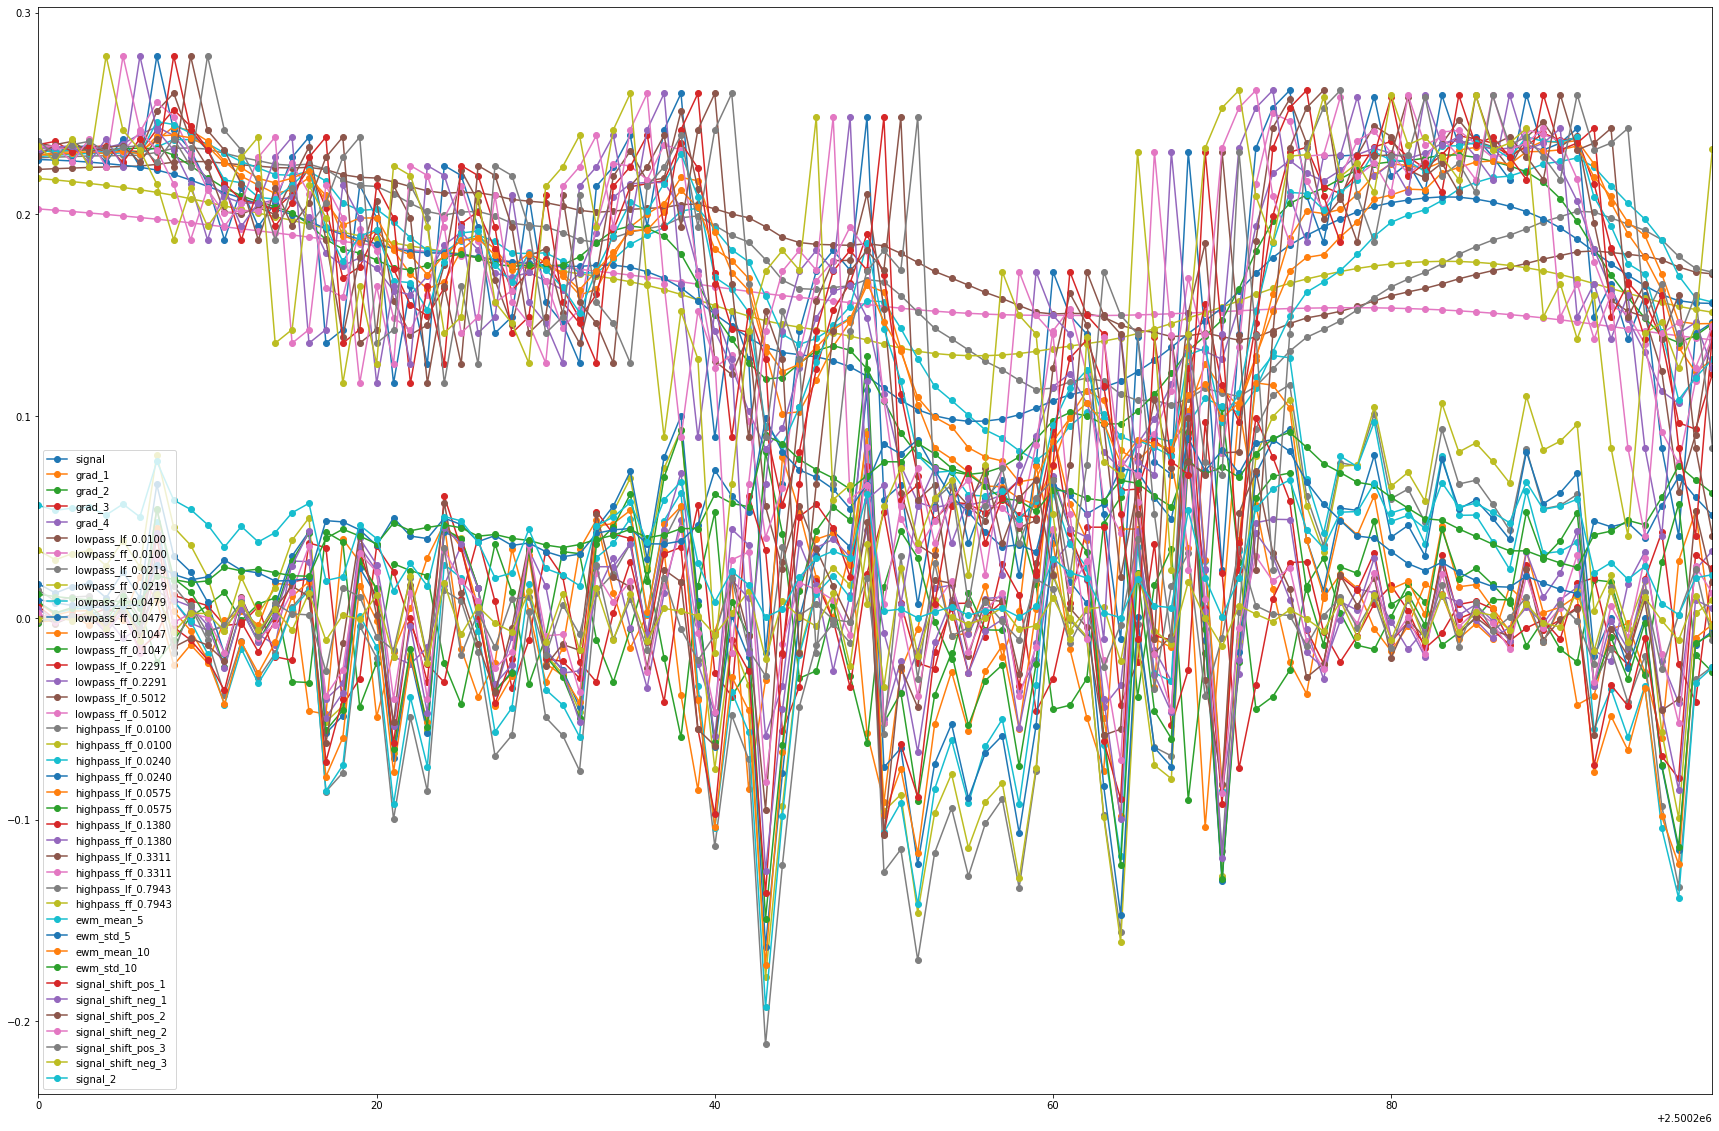

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(30, 20))
demo_cols = []
nstart = 500000*5+200
nstep = 100
# for col in use_cols:
#     if col.find('ewm')!=-1:
#         demo_cols.append(col)
demo_cols = use_cols
print(demo_cols)
ts1_sub = ts1.iloc[nstart:nstart+nstep][demo_cols]
print(type(ts1_sub))
ts1_sub.plot(ax = axes, style='o-')
plt.show()